In [ ]:
#Link with Google Drive
URL = '/content/drive/'
from google.colab import drive
drive.mount(URL)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, pctg=1.):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
        if pctg < 1.:
            unique_labels = list(range(len(self.classes)))
            filtered_imgs, filtered_labels = [], []
            for lab in unique_labels:
                ixs = (self.labels == lab)
                lim = int(ixs.sum()*pctg)
                filtered_imgs += self.imgs[ixs][:lim].tolist()
                filtered_labels += self.labels[ixs][:lim].tolist()
            self.imgs, self.labels = np.array(filtered_imgs), np.array(filtered_labels)
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

class SSLDataset(torch.utils.data.Dataset):
    def __init__(self, trans):
        self.trans = trans
        trainset = torchvision.datasets.CIFAR10(root='"/content/drive/MyDrive/SimCLR_components/data"', train=True, download=True)
        self.imgs = np.array([np.array(i[0]) for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        img1 = self.trans(image=img)['image']
        img2 = self.trans(image=img)['image']
        return torch.from_numpy(img1 / 255.).permute(2,0,1).float(), torch.from_numpy(img2 / 255.).permute(2,0,1).float()

In [ ]:
batch_size = 1024
num_workers = 24

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda"):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

def plot_hist(hist):
  fig = plt.figure(figsize=(10, 3), dpi=100)
  df = pd.DataFrame(hist)
  ax = plt.subplot(1, 2, 1)
  df[['loss', 'test_loss']].plot(ax=ax)
  ax.grid(True)
  ax = plt.subplot(1, 2, 2)
  df[['acc', 'test_acc']].plot(ax=ax)
  ax.grid(True)
  plt.show()

In [ ]:
import albumentations as A

trans = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.ToGray(p=0.3),
    #A.GaussianBlur(),
    A.Solarize(p=0.3)
])

SSLds = SSLDataset(trans)

Files already downloaded and verified


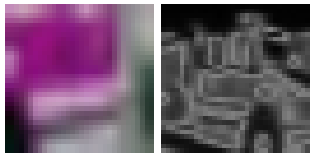

In [ ]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(SSLds))
img1, img2 = SSLds[ix]
fig = plt.figure(dpi=50)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1.permute(1,2,0))
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(img2.permute(1,2,0))
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class SSLModel(torch.nn.Module):

    def __init__(self, f=512):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
SSLmodel = SSLModel()
output = SSLmodel(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 512])

In [ ]:
import copy

class FTModel(torch.nn.Module):

    def __init__(self, backbone='SSLbackbone.pt', n_outputs=10):
        super().__init__()
        self.backbone = torch.jit.load(backbone)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, n_outputs)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
from tqdm import tqdm

def SSLeval(SSLmodel):
    torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')
    ds = {
        'train': Dataset(),
        'test': Dataset(train=False)
    }
    batch_size = 1024
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }
    FTmodel = FTModel('SSLbackbone.pt')
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=1e-3)
    hist = train(FTmodel, dl, optimizer, epochs=3)
    return hist['acc'][-1], hist['test_acc'][-1]

def SSLstep(model, batch, device, l=5e-3):
    # Dos versiones aumentadas aleatoriamente de x
    x1, x2 = batch
    x1, x2 = x1.to(device), x2.to(device)

    # Calcular representaciones
    z1 = model(x1)
    z2 = model(x2)

    # normalizar repr. a lo largo de la dimensión del batch
    N, D = z1.shape
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD

    # Matriz de cross-correlation
    c = (z1_norm.T @ z2_norm) / N # DxD

    # loss
    c_diff = (c - torch.eye(D, device=device)).pow(2) # DxD

    # multiplicar elementos fuera de la diagonal de c_diff por lambda
    d = torch.eye(D, dtype=bool)
    c_diff[~d] *= l
    return c_diff.sum()

def SSLtrain(model, dl, optimizer, scheduler, epochs=10, device="cuda", eval_each=10):
    hist = {'loss': [], 'acc': [], 'test_acc': []}
    for e in range(1, epochs+1):
        model.to(device)
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl)
        for batch in bar:
            optimizer.zero_grad()
            loss = SSLstep(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            bar.set_description(f"training... loss {np.mean(l):.4f}")
        hist['loss'].append(np.mean(l))
        scheduler.step()
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            if len(v) > 0:
                log += f' {k} {v[-1]:.4f}'
        print(log)
        # eval
        if not e % eval_each:
            print("evaluating ...")
            val_train_acc, val_test_acc = SSLeval(model)
            hist['acc'].append(val_train_acc)
            hist['test_acc'].append(val_test_acc)
    return hist

In [ ]:
SSLdl = torch.utils.data.DataLoader(SSLds, batch_size=1024, shuffle=True, num_workers=num_workers)
SSLmodel = SSLModel()
optimizer = torch.optim.Adam(SSLmodel.parameters(), lr=1e-4)
epochs = 500
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.01, max_lr=0.1, total_steps=epochs, verbose=True)
hist = SSLtrain(SSLmodel, SSLdl, optimizer, scheduler, epochs=epochs)

Adjusting learning rate of group 0 to 4.0000e-03.


training... loss 266.7206: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 1.8059e-02.
Epoch 1/500 loss 266.7206


training... loss 208.6038: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 5.2000e-02.
Epoch 2/500 loss 208.6038


training... loss 187.8893: 100%|██████████| 49/49 [00:43<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 8.5941e-02.
Epoch 3/500 loss 187.8893


training... loss 167.6310: 100%|██████████| 49/49 [00:45<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4/500 loss 167.6310


training... loss 158.1103: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 9.9999e-02.
Epoch 5/500 loss 158.1103


training... loss 150.6902: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9996e-02.
Epoch 6/500 loss 150.6902


training... loss 146.7346: 100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 9.9991e-02.
Epoch 7/500 loss 146.7346


training... loss 140.0461: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9984e-02.
Epoch 8/500 loss 140.0461


training... loss 132.8457: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 9.9975e-02.
Epoch 9/500 loss 132.8457


training... loss 127.6053: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9964e-02.
Epoch 10/500 loss 127.6053
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.7750 acc 0.3234: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch 1/3 loss 1.8995 acc 0.2919 test_loss 1.7750 test_acc 0.3234


testing... loss 1.7611 acc 0.3420: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


Epoch 2/3 loss 1.7690 acc 0.3254 test_loss 1.7611 test_acc 0.3420


testing... loss 1.7514 acc 0.3454: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Epoch 3/3 loss 1.7603 acc 0.3337 test_loss 1.7514 test_acc 0.3454


training... loss 125.1333: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.9951e-02.
Epoch 11/500 loss 125.1333 acc 0.3337 test_acc 0.3454


training... loss 125.2524: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9936e-02.
Epoch 12/500 loss 125.2524 acc 0.3337 test_acc 0.3454


training... loss 120.6025: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9918e-02.
Epoch 13/500 loss 120.6025 acc 0.3337 test_acc 0.3454


training... loss 118.5832: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 9.9899e-02.
Epoch 14/500 loss 118.5832 acc 0.3337 test_acc 0.3454


training... loss 115.9805: 100%|██████████| 49/49 [00:42<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 9.9878e-02.
Epoch 15/500 loss 115.9805 acc 0.3337 test_acc 0.3454


training... loss 114.6910: 100%|██████████| 49/49 [00:44<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.9855e-02.
Epoch 16/500 loss 114.6910 acc 0.3337 test_acc 0.3454


training... loss 112.7384: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 9.9830e-02.
Epoch 17/500 loss 112.7384 acc 0.3337 test_acc 0.3454


training... loss 111.1957: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 9.9803e-02.
Epoch 18/500 loss 111.1957 acc 0.3337 test_acc 0.3454


training... loss 111.9300: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9774e-02.
Epoch 19/500 loss 111.9300 acc 0.3337 test_acc 0.3454


training... loss 107.6336: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s]


Adjusting learning rate of group 0 to 9.9742e-02.
Epoch 20/500 loss 107.6336 acc 0.3337 test_acc 0.3454
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.7542 acc 0.3427: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Epoch 1/3 loss 2.0209 acc 0.2860 test_loss 1.7542 test_acc 0.3427


testing... loss 1.7181 acc 0.3719: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Epoch 2/3 loss 1.7298 acc 0.3562 test_loss 1.7181 test_acc 0.3719


testing... loss 1.6944 acc 0.3780: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


Epoch 3/3 loss 1.7012 acc 0.3686 test_loss 1.6944 test_acc 0.3780


training... loss 107.7060: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9709e-02.
Epoch 21/500 loss 107.7060 acc 0.3686 test_acc 0.3780


training... loss 107.0838: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 9.9674e-02.
Epoch 22/500 loss 107.0838 acc 0.3686 test_acc 0.3780


training... loss 106.8946: 100%|██████████| 49/49 [00:44<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.9637e-02.
Epoch 23/500 loss 106.8946 acc 0.3686 test_acc 0.3780


training... loss 104.1895: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


Adjusting learning rate of group 0 to 9.9598e-02.
Epoch 24/500 loss 104.1895 acc 0.3686 test_acc 0.3780


training... loss 103.5212: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.9557e-02.
Epoch 25/500 loss 103.5212 acc 0.3686 test_acc 0.3780


training... loss 102.7354: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.9513e-02.
Epoch 26/500 loss 102.7354 acc 0.3686 test_acc 0.3780


training... loss 100.6438: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 9.9468e-02.
Epoch 27/500 loss 100.6438 acc 0.3686 test_acc 0.3780


training... loss 100.2217: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.9421e-02.
Epoch 28/500 loss 100.2217 acc 0.3686 test_acc 0.3780


training... loss 100.2054: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 9.9372e-02.
Epoch 29/500 loss 100.2054 acc 0.3686 test_acc 0.3780


training... loss 100.4352: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.9321e-02.
Epoch 30/500 loss 100.4352 acc 0.3686 test_acc 0.3780
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.7496 acc 0.3492: 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Epoch 1/3 loss 2.3604 acc 0.2645 test_loss 1.7496 test_acc 0.3492


testing... loss 1.6690 acc 0.3850: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Epoch 2/3 loss 1.6802 acc 0.3716 test_loss 1.6690 test_acc 0.3850


testing... loss 1.6464 acc 0.3938: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Epoch 3/3 loss 1.6387 acc 0.3899 test_loss 1.6464 test_acc 0.3938


training... loss 98.5845: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9268e-02.
Epoch 31/500 loss 98.5845 acc 0.3899 test_acc 0.3938


training... loss 98.1546: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s]


Adjusting learning rate of group 0 to 9.9213e-02.
Epoch 32/500 loss 98.1546 acc 0.3899 test_acc 0.3938


training... loss 97.6991: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9156e-02.
Epoch 33/500 loss 97.6991 acc 0.3899 test_acc 0.3938


training... loss 95.6900: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


Adjusting learning rate of group 0 to 9.9096e-02.
Epoch 34/500 loss 95.6900 acc 0.3899 test_acc 0.3938


training... loss 94.3683: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.9035e-02.
Epoch 35/500 loss 94.3683 acc 0.3899 test_acc 0.3938


training... loss 95.4136: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 9.8972e-02.
Epoch 36/500 loss 95.4136 acc 0.3899 test_acc 0.3938


training... loss 93.9331: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 9.8907e-02.
Epoch 37/500 loss 93.9331 acc 0.3899 test_acc 0.3938


training... loss 93.1944: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 9.8840e-02.
Epoch 38/500 loss 93.1944 acc 0.3899 test_acc 0.3938


training... loss 92.5531: 100%|██████████| 49/49 [00:45<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.8771e-02.
Epoch 39/500 loss 92.5531 acc 0.3899 test_acc 0.3938


training... loss 92.1077: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


Adjusting learning rate of group 0 to 9.8701e-02.
Epoch 40/500 loss 92.1077 acc 0.3899 test_acc 0.3938
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.6411 acc 0.3956: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Epoch 1/3 loss 2.1754 acc 0.2991 test_loss 1.6411 test_acc 0.3956


testing... loss 1.5779 acc 0.4209: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Epoch 2/3 loss 1.5853 acc 0.4151 test_loss 1.5779 test_acc 0.4209


testing... loss 1.5536 acc 0.4301: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Epoch 3/3 loss 1.5420 acc 0.4319 test_loss 1.5536 test_acc 0.4301


training... loss 90.7211: 100%|██████████| 49/49 [00:48<00:00,  1.01it/s]


Adjusting learning rate of group 0 to 9.8628e-02.
Epoch 41/500 loss 90.7211 acc 0.4319 test_acc 0.4301


training... loss 90.7119: 100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 9.8553e-02.
Epoch 42/500 loss 90.7119 acc 0.4319 test_acc 0.4301


training... loss 88.3594: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.8476e-02.
Epoch 43/500 loss 88.3594 acc 0.4319 test_acc 0.4301


training... loss 88.8623: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s]


Adjusting learning rate of group 0 to 9.8397e-02.
Epoch 44/500 loss 88.8623 acc 0.4319 test_acc 0.4301


training... loss 89.2743: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 9.8317e-02.
Epoch 45/500 loss 89.2743 acc 0.4319 test_acc 0.4301


training... loss 88.4747: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s]


Adjusting learning rate of group 0 to 9.8234e-02.
Epoch 46/500 loss 88.4747 acc 0.4319 test_acc 0.4301


training... loss 87.4967: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 9.8150e-02.
Epoch 47/500 loss 87.4967 acc 0.4319 test_acc 0.4301


training... loss 87.2047: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 9.8063e-02.
Epoch 48/500 loss 87.2047 acc 0.4319 test_acc 0.4301


training... loss 86.2938: 100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 9.7975e-02.
Epoch 49/500 loss 86.2938 acc 0.4319 test_acc 0.4301


training... loss 86.3128: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.7884e-02.
Epoch 50/500 loss 86.3128 acc 0.4319 test_acc 0.4301
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.6212 acc 0.4062: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch 1/3 loss 2.3327 acc 0.2910 test_loss 1.6212 test_acc 0.4062


testing... loss 1.5404 acc 0.4317: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 2/3 loss 1.5470 acc 0.4223 test_loss 1.5404 test_acc 0.4317


testing... loss 1.5092 acc 0.4412: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch 3/3 loss 1.5003 acc 0.4450 test_loss 1.5092 test_acc 0.4412


training... loss 85.5802: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s]


Adjusting learning rate of group 0 to 9.7792e-02.
Epoch 51/500 loss 85.5802 acc 0.4450 test_acc 0.4412


training... loss 85.1871: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.7698e-02.
Epoch 52/500 loss 85.1871 acc 0.4450 test_acc 0.4412


training... loss 85.1566: 100%|██████████| 49/49 [00:49<00:00,  1.00s/it]


Adjusting learning rate of group 0 to 9.7602e-02.
Epoch 53/500 loss 85.1566 acc 0.4450 test_acc 0.4412


training... loss 84.9190: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.7504e-02.
Epoch 54/500 loss 84.9190 acc 0.4450 test_acc 0.4412


training... loss 84.3515: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.7404e-02.
Epoch 55/500 loss 84.3515 acc 0.4450 test_acc 0.4412


training... loss 83.2506: 100%|██████████| 49/49 [00:49<00:00,  1.00s/it]


Adjusting learning rate of group 0 to 9.7302e-02.
Epoch 56/500 loss 83.2506 acc 0.4450 test_acc 0.4412


training... loss 83.5989: 100%|██████████| 49/49 [00:46<00:00,  1.05it/s]


Adjusting learning rate of group 0 to 9.7198e-02.
Epoch 57/500 loss 83.5989 acc 0.4450 test_acc 0.4412


training... loss 82.3742: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.7092e-02.
Epoch 58/500 loss 82.3742 acc 0.4450 test_acc 0.4412


training... loss 81.7709: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.6985e-02.
Epoch 59/500 loss 81.7709 acc 0.4450 test_acc 0.4412


training... loss 81.5223: 100%|██████████| 49/49 [00:45<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.6875e-02.
Epoch 60/500 loss 81.5223 acc 0.4450 test_acc 0.4412
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.5730 acc 0.4169: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 1/3 loss 2.4299 acc 0.2998 test_loss 1.5730 test_acc 0.4169


testing... loss 1.4919 acc 0.4435: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 2/3 loss 1.5135 acc 0.4430 test_loss 1.4919 test_acc 0.4435


testing... loss 1.4646 acc 0.4606: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch 3/3 loss 1.4641 acc 0.4641 test_loss 1.4646 test_acc 0.4606


training... loss 81.9756: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.6764e-02.
Epoch 61/500 loss 81.9756 acc 0.4641 test_acc 0.4606


training... loss 81.4250: 100%|██████████| 49/49 [00:48<00:00,  1.00it/s]


Adjusting learning rate of group 0 to 9.6651e-02.
Epoch 62/500 loss 81.4250 acc 0.4641 test_acc 0.4606


training... loss 79.9971: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.6535e-02.
Epoch 63/500 loss 79.9971 acc 0.4641 test_acc 0.4606


training... loss 80.2456: 100%|██████████| 49/49 [00:44<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.6418e-02.
Epoch 64/500 loss 80.2456 acc 0.4641 test_acc 0.4606


training... loss 80.1361: 100%|██████████| 49/49 [00:49<00:00,  1.00s/it]


Adjusting learning rate of group 0 to 9.6300e-02.
Epoch 65/500 loss 80.1361 acc 0.4641 test_acc 0.4606


training... loss 81.5848: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.6179e-02.
Epoch 66/500 loss 81.5848 acc 0.4641 test_acc 0.4606


training... loss 79.2586: 100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 9.6056e-02.
Epoch 67/500 loss 79.2586 acc 0.4641 test_acc 0.4606


training... loss 79.0211: 100%|██████████| 49/49 [00:48<00:00,  1.00it/s]


Adjusting learning rate of group 0 to 9.5932e-02.
Epoch 68/500 loss 79.0211 acc 0.4641 test_acc 0.4606


training... loss 79.5503: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 9.5805e-02.
Epoch 69/500 loss 79.5503 acc 0.4641 test_acc 0.4606


training... loss 79.8979: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.5677e-02.
Epoch 70/500 loss 79.8979 acc 0.4641 test_acc 0.4606
evaluating ...
Files already downloaded and verified
Files already downloaded and verified


testing... loss 1.5681 acc 0.4330: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 1/3 loss 2.4089 acc 0.3262 test_loss 1.5681 test_acc 0.4330


testing... loss 1.4598 acc 0.4691: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Epoch 2/3 loss 1.4887 acc 0.4499 test_loss 1.4598 test_acc 0.4691


testing... loss 1.4246 acc 0.4852: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 3/3 loss 1.4391 acc 0.4653 test_loss 1.4246 test_acc 0.4852


training... loss 78.3618: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.5547e-02.
Epoch 71/500 loss 78.3618 acc 0.4653 test_acc 0.4852


training... loss 77.5182: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.5415e-02.
Epoch 72/500 loss 77.5182 acc 0.4653 test_acc 0.4852


training... loss 78.2852: 100%|██████████| 49/49 [00:48<00:00,  1.01it/s]


Adjusting learning rate of group 0 to 9.5282e-02.
Epoch 73/500 loss 78.2852 acc 0.4653 test_acc 0.4852


training... loss 79.2693: 100%|██████████| 49/49 [00:46<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 9.5146e-02.
Epoch 74/500 loss 79.2693 acc 0.4653 test_acc 0.4852


training... loss 77.2804: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.5009e-02.
Epoch 75/500 loss 77.2804 acc 0.4653 test_acc 0.4852


training... loss 74.8938:  80%|███████▉  | 39/49 [00:43<00:03,  2.96it/s]

In [ ]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
ax.plot(hist['loss'])
ax.legend(['loss'])
ax.grid(True)
ax = plt.subplot(1, 2, 2)
ax.plot(hist['acc'])
ax.plot(hist['test_acc'])
ax.legend(['acc', 'test_acc'])
ax.grid(True)
plt.show()